Logistic Regression Accuracy: 0.8101
Random Forest Accuracy: 0.8212
XGBoost Accuracy: 0.8324
Stacking Accuracy: 0.8212


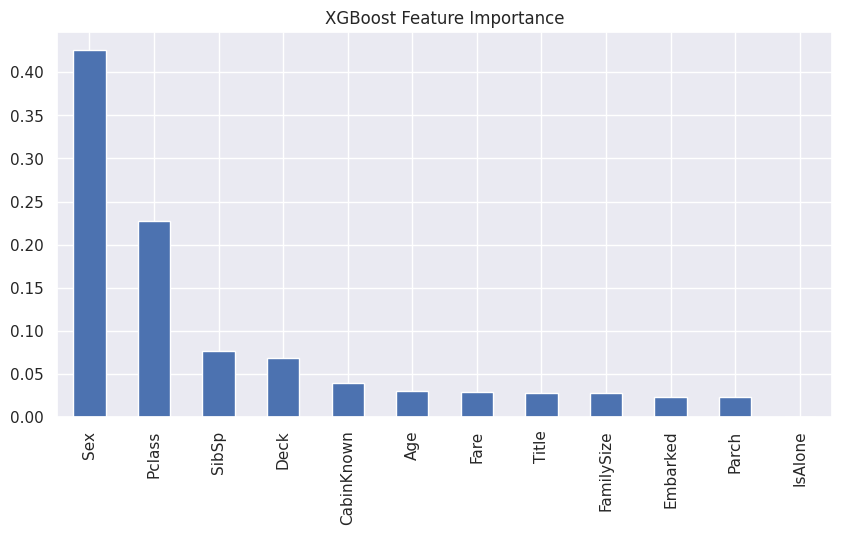

Submission file created: titanic_submission.csv


In [15]:
# =========================
# Titanic Full Pipeline: Cleaning + Feature Engineering + Models + Submission
# =========================

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# --------------------------
# 1. Load data
# --------------------------
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

# --------------------------
# 2. Fill missing values
# --------------------------
# Age: تعويض حسب Pclass + Sex
train['Age'] = train.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
test['Age']  = test.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

# Fare: تعويض القيمة المفقودة في test
test['Fare'].fillna(test['Fare'].median(), inplace=True)

# Embarked: تعويض بالقيمة الأكثر تكرارًا
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

# Cabin: نشتق ميزتين
train['CabinKnown'] = train['Cabin'].notnull().astype(int)
test['CabinKnown']  = test['Cabin'].notnull().astype(int)
train['Deck'] = train['Cabin'].str[0].fillna('U')
test['Deck']  = test['Cabin'].str[0].fillna('U')

# --------------------------
# 3. Feature Engineering
# --------------------------
# Title من Name
train['Title'] = train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
test['Title']  = test['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# دمج العناوين النادرة
rare_titles = ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona']
train['Title'] = train['Title'].replace(rare_titles, 'Rare')
test['Title']  = test['Title'].replace(rare_titles, 'Rare')

# توحيد بعض العناوين
train['Title'] = train['Title'].replace({'Mlle':'Miss','Ms':'Miss','Mme':'Mrs'})
test['Title']  = test['Title'].replace({'Mlle':'Miss','Ms':'Miss','Mme':'Mrs'})

# FamilySize و IsAlone
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize']  = test['SibSp'] + test['Parch'] + 1
train['IsAlone'] = (train['FamilySize'] == 1).astype(int)
test['IsAlone']  = (test['FamilySize'] == 1).astype(int)

# --------------------------
# 4. Encode categorical features
# --------------------------
categorical_cols = ['Sex','Embarked','Title','Deck']
for c in categorical_cols:
    le = LabelEncoder()
    train[c] = le.fit_transform(train[c])
    test[c]  = le.transform(test[c])

# --------------------------
# 5. Drop unused columns
# --------------------------
drop_cols = ['PassengerId','Name','Ticket','Cabin']
train = train.drop(drop_cols, axis=1)
test  = test.drop(drop_cols, axis=1)

# --------------------------
# 6. Split X, y
# --------------------------
X = train.drop('Survived', axis=1)
y = train['Survived']

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(test)

# --------------------------
# 7. Train/Validation split
# --------------------------
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --------------------------
# 8. Define models
# --------------------------
logreg = LogisticRegression(random_state=42)
rf     = RandomForestClassifier(n_estimators=300, max_depth=6, random_state=42)
xgb    = XGBClassifier(n_estimators=300, max_depth=4, learning_rate=0.1,
                       use_label_encoder=False, eval_metric='logloss', random_state=42)

# Stacking: RF + XGB → meta model Logistic Regression
estimators = [('rf', rf), ('xgb', xgb)]
stack_model = StackingClassifier(estimators=estimators, final_estimator=logreg, cv=5)

# --------------------------
# 9. Train models
# --------------------------
logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
stack_model.fit(X_train, y_train)

# --------------------------
# 10. Evaluate models
# --------------------------
models = {'Logistic Regression': logreg, 'Random Forest': rf, 'XGBoost': xgb, 'Stacking': stack_model}

for name, model in models.items():
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

# --------------------------
# 11. Feature Importance (XGBoost)
# --------------------------
feat_importances = pd.Series(xgb.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("XGBoost Feature Importance")
plt.show()

# --------------------------
# 12. Prepare submission using Stacking model
# --------------------------
test_preds = stack_model.predict(X_test_scaled)
submission = pd.DataFrame({
    'PassengerId': pd.read_csv("test.csv")['PassengerId'],
    'Survived': test_preds
})
submission.to_csv("titanic_submission.csv", index=False)
print("Submission file created: titanic_submission.csv")
